# alice-loves-bob

This experiment was presented at [QNLP 2019](file:///Users/alexis.toumi/WORK/discopy/docs/_build/html/talks/qnlp19.html).

In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice, loves, Bob = Word('Alice', n), Word('loves', n.r @ s @ n.l), Word('Bob', n)

print("Vocabulary:\n{}".format('\n'.join(map(repr, [Alice, loves, Bob]))))

Vocabulary:
Word('Alice', Ty('n'))
Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1)))
Word('Bob', Ty('n'))


Diagram for 'Alice loves Bob':


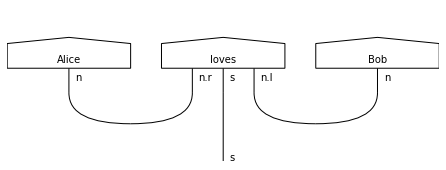

In [2]:
from discopy import Diagram, Id, Cup
from discopy.grammar import draw

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
parsing = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj >> grammar
            for subj in [Alice, Bob] for verb in [loves] for obj in [Alice, Bob]}

diagram = parsing['Alice loves Bob.']
print("Diagram for 'Alice loves Bob':")
draw(diagram, draw_type_labels=True)

In [8]:
parsing

{'Alice loves Alice.': Diagram(dom=Ty(), cod=Ty('s'), boxes=[Word('Alice', Ty('n')), Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1))), Word('Alice', Ty('n')), Cup(Ty('n'), Ty(Ob('n', z=1))), Cup(Ty(Ob('n', z=-1)), Ty('n'))], offsets=[0, 1, 4, 0, 1]),
 'Alice loves Bob.': Diagram(dom=Ty(), cod=Ty('s'), boxes=[Word('Alice', Ty('n')), Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1))), Word('Bob', Ty('n')), Cup(Ty('n'), Ty(Ob('n', z=1))), Cup(Ty(Ob('n', z=-1)), Ty('n'))], offsets=[0, 1, 4, 0, 1]),
 'Bob loves Alice.': Diagram(dom=Ty(), cod=Ty('s'), boxes=[Word('Bob', Ty('n')), Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1))), Word('Alice', Ty('n')), Cup(Ty('n'), Ty(Ob('n', z=1))), Cup(Ty(Ob('n', z=-1)), Ty('n'))], offsets=[0, 1, 4, 0, 1]),
 'Bob loves Bob.': Diagram(dom=Ty(), cod=Ty('s'), boxes=[Word('Bob', Ty('n')), Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1))), Word('Bob', Ty('n')), Cup(Ty('n'), Ty(Ob('n', z=1))), Cup(Ty(Ob('n', z=-1)), Ty('n'))], offsets=[0, 1, 4, 0, 1])}

display all possible sentences

In [3]:
sentences = list(parsing.keys())
print("Grammatical sentences:\n{}".format('\n'.join(sentences)))

Grammatical sentences:
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.


In [4]:
from discopy.quantum import Ket, H, Rx, CX, sqrt

def verb_ansatz(phase):
    return Ket(0, 0) >> H @ sqrt(2) @ Rx(phase) >> CX

print(verb_ansatz(0).eval())

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])


In [5]:
(verb_ansatz(0) >> verb_ansatz(0.5).dagger()).measure()

array([1.49975978e-32])

In [6]:
.25 * (verb_ansatz(0) >> verb_ansatz(0).dagger()).measure()

array([1.])

We create an ansatz for the verb "loves" and put 0.5 as the parameter

Circuit for 'Alice loves Bob':


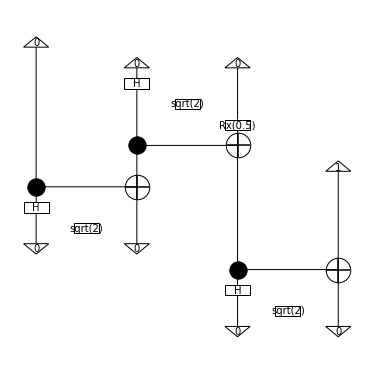

In [7]:
from discopy import CircuitFunctor, qubit

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0), Bob: Ket(1),
    loves: verb_ansatz(params['loves'])}

F = lambda params: CircuitFunctor(ob, ar(params))

params0 = {'loves': 0.5}

print("Circuit for 'Alice loves Bob':")
F(params0)(parsing['Alice loves Bob.']).draw(
    aspect='auto', draw_type_labels=False, figsize=(5, 5))

In [12]:
F(params0)

circuit.Functor(ob={Ty('s'): Ty(), Ty('n'): qubit}, ar={Word('Alice', Ty('n')): Ket(0), Word('Bob', Ty('n')): Ket(1), Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): Circuit(dom=Ty(), cod=qubit @ qubit, boxes=[Ket(0, 0), H, sqrt(2), Rx(0.5), CX], offsets=[0, 0, 1, 1, 0])})

In [11]:
loves

Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1)))

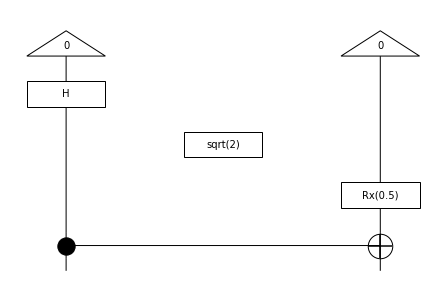

In [10]:
F(params0)(loves).draw()

In [15]:
print("Amplitude for 'Alice loves Bob':")
print(F(params0)(parsing['Alice loves Bob.']).eval())

Amplitude for 'Alice loves Bob':
Tensor(dom=Dim(1), cod=Dim(1), array=[0.-0.99999988j])


In [33]:
evaluate = lambda F, sentence: F(parsing[sentence]).measure()

print("Does Alice love Bob?\n{}".format(
    "Yes" if float(evaluate(F(params0), 'Alice loves Bob.'))>0.5 else "No"))

Does Alice love Bob?
Yes


In [32]:
print("Does Alice love Alice?\n{}".format(
    "Yes" if float(evaluate(F(params0), 'Alice loves Alice.'))>0.5 else "No"))

Does Alice love Alice?
No


With parameter 0.5 the ansatz works, and returns the correct asnwer

In [34]:
corpus = {sentence: evaluate(F(params0), sentence) for sentence in sentences}

epsilon = 1e-2

print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability > 1 - epsilon)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability < epsilon)))

True sentences:
Alice loves Bob.
Bob loves Alice.

False sentences:
Alice loves Alice.
Bob loves Bob.


In [35]:
corpus

{'Alice loves Alice.': DeviceArray([1.9106853e-15], dtype=float32),
 'Alice loves Bob.': DeviceArray([0.99999976], dtype=float32),
 'Bob loves Alice.': DeviceArray([0.99999976], dtype=float32),
 'Bob loves Bob.': DeviceArray([1.9106853e-15], dtype=float32)}

In [36]:
import jax.numpy as np
from jax import grad

from discopy import Tensor

Tensor.np = np  # This ensures we can differentiate Circuit.eval with respect to phases.

def mean_squared(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

f = lambda phase: mean_squared(*zip(*[
    (evaluate(F(params0), sentence), evaluate(F({'loves': phase}), sentence))
     for sentence in sentences])) # cost function to optimise 

grad(f)(0.75)

DeviceArray(3.141591, dtype=float32)

In [37]:
from jax import vmap

x = np.arange(0.0, 1.0, 0.01) # scanning the paramater theta over [0,1]
y = vmap(f)(x) # evaluates the function at all the points
dy = vmap(grad(f))(x)# evaluates the dradient at function at all the points

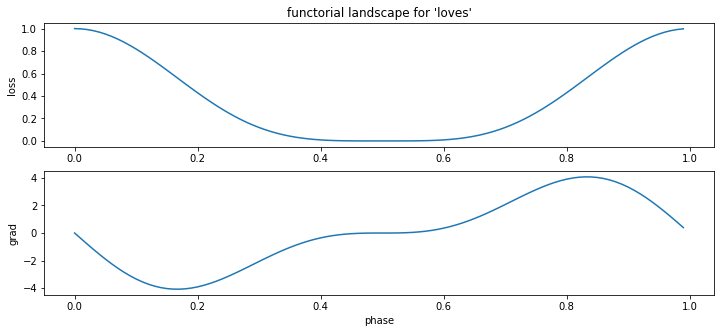

In [38]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.title("functorial landscape for 'loves'")
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(x, dy)
plt.xlabel('phase')
plt.ylabel('grad')
plt.show()

Already possible to see the optimum is 0.5

In [39]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.25, random_state=42)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(
    lambda x: 'Does ' + x.replace('loves', 'love').replace('.', '?'), sentence_test))))

Training set:
Bob loves Bob.
Alice loves Alice.
Bob loves Alice.

Testing set:
Does Alice love Bob?


In [40]:
from jax import jit
from time import time

loss = {sentence: lambda params: mean_squared(corpus[sentence], evaluate(F(params), sentence))
                 for sentence in sentences}

@jit
def testing_loss(params):
    return np.mean(np.array([loss[sentence](params) for sentence in sentence_test]))

start = time()
print("{1:.3f} seconds to compile the testing loss of params0 ({0})".format(
    testing_loss(params0), time() - start))

step_size = 1e-2

@jit
def update(params):
    for sentence in sentence_train:
        params = {word: phase - step_size * grad(loss[sentence])(params)[word]
                  for word, phase in params.items()}
    return params

start = time()
print("{1:.3f} seconds to compile the update function just in time:\n{0}".format(
    update(params0), time() - start))

0.256 seconds to compile the testing loss of params0 (0.0)
1.017 seconds to compile the update function just in time:
{'loves': DeviceArray(0.5, dtype=float32)}


In [41]:
from random import random, seed; seed(420)

print("Random parameter initialisation...")

params = {'loves': random()}
print("Initial parameters: {}".format(params))

print("Initial testing loss: {:.5f}\n".format(testing_loss(params)))

epochs, iterations = 7, 10

for epoch in range(epochs):
    start = time()
    for i in range(iterations):
        params = update(params)

    print("Epoch {} ({:.3f} milliseconds)".format(epoch, 1e3 * (time() - start)))
    print("Testing loss: {:.5f}".format(testing_loss(params)))
    print("params['loves'] = {:.3f}\n".format(params['loves']))

Random parameter initialisation...
Initial parameters: {'loves': 0.026343380459525556}
Initial testing loss: 0.98638

Epoch 0 (1.354 milliseconds)
Testing loss: 0.00321
params['loves'] = 0.424

Epoch 1 (0.764 milliseconds)
Testing loss: 0.00060
params['loves'] = 0.450

Epoch 2 (0.734 milliseconds)
Testing loss: 0.00024
params['loves'] = 0.460

Epoch 3 (0.440 milliseconds)
Testing loss: 0.00013
params['loves'] = 0.466

Epoch 4 (0.710 milliseconds)
Testing loss: 0.00008
params['loves'] = 0.470

Epoch 5 (0.715 milliseconds)
Testing loss: 0.00005
params['loves'] = 0.473

Epoch 6 (0.706 milliseconds)
Testing loss: 0.00004
params['loves'] = 0.475



In [42]:
print("Does Alice love Bob?")
print("Yes" if evaluate(F(params), 'Alice loves Bob.') > 1 - epsilon else "No")

Does Alice love Bob?
Yes
